# Imputing 


# Data Acquisition 

In [1]:
#import libraries
import pandas as pd
import numpy as np
import acquire
import modeling_scaling
#visualization libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
pd.set_option('display.max_columns', None)
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

In [2]:
df = pd.read_csv("credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [4]:
# for use later after mvp
# df_no_age = acquire.wrangle(df)

In [5]:
train, validate, test=acquire.split_credit_defult_df(df)
train.shape, validate.shape, test.shape

((18244, 12), (7820, 12), (6517, 12))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18244 entries, 19101 to 19023
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  18244 non-null  int64  
 1   person_income               18244 non-null  int64  
 2   person_home_ownership       18244 non-null  object 
 3   person_emp_length           17765 non-null  float64
 4   loan_intent                 18244 non-null  object 
 5   loan_grade                  18244 non-null  object 
 6   loan_amnt                   18244 non-null  int64  
 7   loan_int_rate               16463 non-null  float64
 8   loan_status                 18244 non-null  int64  
 9   loan_percent_income         18244 non-null  float64
 10  cb_person_default_on_file   18244 non-null  object 
 11  cb_person_cred_hist_length  18244 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 1.8+ MB


### encode the categorical and ordinal variables for imputing purposes

In [7]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
train["loan_grade_code"] = ord_enc.fit_transform(train[["loan_grade"]])
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_grade_code
19101,30,30000,OWN,14.0,PERSONAL,A,5000,7.14,0,0.17,N,7,0.0
15987,25,85000,MORTGAGE,9.0,MEDICAL,A,4000,7.88,0,0.05,N,3,0.0
5348,24,39000,MORTGAGE,8.0,HOMEIMPROVEMENT,C,5000,NaN,1,0.13,N,3,2.0
5269,24,50000,RENT,8.0,MEDICAL,B,5000,9.25,0,0.10,N,3,1.0
23479,29,63000,OWN,0.0,MEDICAL,B,9000,NaN,0,0.14,N,9,1.0


In [8]:
# encode the categorical and ordinal variables
dummy_df = pd.get_dummies(train[["person_home_ownership", "loan_intent","cb_person_default_on_file"]], dummy_na =False, drop_first = [True,True])
encoded_train = pd.concat([train, dummy_df], axis = 1)
encoded_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_grade_code,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
19101,30,30000,OWN,14.0,PERSONAL,A,5000,7.14,0,0.17,N,7,0.0,0,1,0,0,0,0,1,0,0
15987,25,85000,MORTGAGE,9.0,MEDICAL,A,4000,7.88,0,0.05,N,3,0.0,0,0,0,0,0,1,0,0,0
5348,24,39000,MORTGAGE,8.0,HOMEIMPROVEMENT,C,5000,NaN,1,0.13,N,3,2.0,0,0,0,0,1,0,0,0,0
5269,24,50000,RENT,8.0,MEDICAL,B,5000,9.25,0,0.10,N,3,1.0,0,0,1,0,0,1,0,0,0
23479,29,63000,OWN,0.0,MEDICAL,B,9000,NaN,0,0.14,N,9,1.0,0,1,0,0,0,1,0,0,0


In [9]:
#scale the data
columns_to_scale =  ["person_age","person_income","loan_amnt","loan_percent_income","cb_person_cred_hist_length"]
train_scaled, validate_scaled, test_scaled  = modeling_scaling.scaling_minmax(train, validate, test, columns_to_scale)


In [10]:
train_scaled_new = train_scaled[["person_age","person_income","loan_amnt","person_emp_length","loan_int_rate","loan_percent_income","cb_person_cred_hist_length"]]


In [11]:
train_scaled_new.head()

,person_age,person_income,loan_amnt,person_emp_length,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
19101,0.080645,0.004303,0.130435,14.0,7.14,0.217949,0.178571
15987,0.040323,0.013476,0.101449,9.0,7.88,0.064103,0.035714
5348,0.032258,0.005804,0.130435,8.0,NaN,0.166667,0.035714
5269,0.032258,0.007639,0.130435,8.0,9.25,0.128205,0.035714
23479,0.072581,0.009807,0.246377,0.0,NaN,0.179487,0.250000


In [12]:
new_train = pd.concat([train, dummy_df, train_scaled_new], axis = 1)


In [13]:
new_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_grade_code,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y,person_age,person_income,loan_amnt,person_emp_length,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
19101,30,30000,OWN,14.0,PERSONAL,A,5000,7.14,0,0.17,N,7,0.0,0,1,0,0,0,0,1,0,0,0.080645,0.004303,0.130435,14.0,7.14,0.217949,0.178571
15987,25,85000,MORTGAGE,9.0,MEDICAL,A,4000,7.88,0,0.05,N,3,0.0,0,0,0,0,0,1,0,0,0,0.040323,0.013476,0.101449,9.0,7.88,0.064103,0.035714
5348,24,39000,MORTGAGE,8.0,HOMEIMPROVEMENT,C,5000,NaN,1,0.13,N,3,2.0,0,0,0,0,1,0,0,0,0,0.032258,0.005804,0.130435,8.0,NaN,0.166667,0.035714
5269,24,50000,RENT,8.0,MEDICAL,B,5000,9.25,0,0.10,N,3,1.0,0,0,1,0,0,1,0,0,0,0.032258,0.007639,0.130435,8.0,9.25,0.128205,0.035714
23479,29,63000,OWN,0.0,MEDICAL,B,9000,NaN,0,0.14,N,9,1.0,0,1,0,0,0,1,0,0,0,0.072581,0.009807,0.246377,0.0,NaN,0.179487,0.250000


In [14]:
df_to_impute = pd.concat([train_scaled_new, dummy_df], axis = 1)


In [15]:
df_to_impute.head()

,person_age,person_income,loan_amnt,person_emp_length,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
19101,0.080645,0.004303,0.130435,14.0,7.14,0.217949,0.178571,0,1,0,0,0,0,1,0,0
15987,0.040323,0.013476,0.101449,9.0,7.88,0.064103,0.035714,0,0,0,0,0,1,0,0,0
5348,0.032258,0.005804,0.130435,8.0,NaN,0.166667,0.035714,0,0,0,0,1,0,0,0,0
5269,0.032258,0.007639,0.130435,8.0,9.25,0.128205,0.035714,0,0,1,0,0,1,0,0,0
23479,0.072581,0.009807,0.246377,0.0,NaN,0.179487,0.250000,0,1,0,0,0,1,0,0,0


In [16]:
df_to_impute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18244 entries, 19101 to 19023
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   18244 non-null  float64
 1   person_income                18244 non-null  float64
 2   loan_amnt                    18244 non-null  float64
 3   person_emp_length            17765 non-null  float64
 4   loan_int_rate                16463 non-null  float64
 5   loan_percent_income          18244 non-null  float64
 6   cb_person_cred_hist_length   18244 non-null  float64
 7   person_home_ownership_OTHER  18244 non-null  uint8  
 8   person_home_ownership_OWN    18244 non-null  uint8  
 9   person_home_ownership_RENT   18244 non-null  uint8  
 10  loan_intent_EDUCATION        18244 non-null  uint8  
 11  loan_intent_HOMEIMPROVEMENT  18244 non-null  uint8  
 12  loan_intent_MEDICAL          18244 non-null  uint8  
 13  loan_intent_

In [17]:
def unique_column(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

In [18]:
df_to_impute = unique_column(df_to_impute)


In [19]:
df_to_impute.head()

,person_age,person_income,loan_amnt,person_emp_length,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
19101,0.080645,0.004303,0.130435,14.0,7.14,0.217949,0.178571,0,1,0,0,0,0,1,0,0
15987,0.040323,0.013476,0.101449,9.0,7.88,0.064103,0.035714,0,0,0,0,0,1,0,0,0
5348,0.032258,0.005804,0.130435,8.0,NaN,0.166667,0.035714,0,0,0,0,1,0,0,0,0
5269,0.032258,0.007639,0.130435,8.0,9.25,0.128205,0.035714,0,0,1,0,0,1,0,0,0
23479,0.072581,0.009807,0.246377,0.0,NaN,0.179487,0.250000,0,1,0,0,0,1,0,0,0


In [20]:
from sklearn.experimental import enable_iterative_imputer


In [21]:
from sklearn.impute import IterativeImputer

In [22]:
X = df_to_impute


In [23]:
# looing at the nan rows
df_with_nan = X[X.isna().any(axis=1)]

In [24]:
# imputing the loan int rate
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
imp = IterativeImputer(estimator = lr)

In [25]:
imp.fit(X)

IterativeImputer(estimator=LinearRegression())

In [26]:
np_imputed = imp.transform(X)

In [27]:

df_imputed = pd.DataFrame(np_imputed, columns=X.columns)

In [28]:
df_imputed.isna().mean()

person_age                     0.0
person_income                  0.0
loan_amnt                      0.0
person_emp_length              0.0
loan_int_rate                  0.0
loan_percent_income            0.0
cb_person_cred_hist_length     0.0
person_home_ownership_OTHER    0.0
person_home_ownership_OWN      0.0
person_home_ownership_RENT     0.0
loan_intent_EDUCATION          0.0
loan_intent_HOMEIMPROVEMENT    0.0
loan_intent_MEDICAL            0.0
loan_intent_PERSONAL           0.0
loan_intent_VENTURE            0.0
cb_person_default_on_file_Y    0.0
dtype: float64

In [29]:
df_imputed_2columns = df_imputed[["loan_int_rate","person_emp_length"]]

In [30]:
imputed_and_concated = pd.concat([df_to_impute, df_imputed_2columns.set_index(df_to_impute.index)], axis=1)


In [31]:
imputed_and_concated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18244 entries, 19101 to 19023
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   18244 non-null  float64
 1   person_income                18244 non-null  float64
 2   loan_amnt                    18244 non-null  float64
 3   person_emp_length            17765 non-null  float64
 4   loan_int_rate                16463 non-null  float64
 5   loan_percent_income          18244 non-null  float64
 6   cb_person_cred_hist_length   18244 non-null  float64
 7   person_home_ownership_OTHER  18244 non-null  uint8  
 8   person_home_ownership_OWN    18244 non-null  uint8  
 9   person_home_ownership_RENT   18244 non-null  uint8  
 10  loan_intent_EDUCATION        18244 non-null  uint8  
 11  loan_intent_HOMEIMPROVEMENT  18244 non-null  uint8  
 12  loan_intent_MEDICAL          18244 non-null  uint8  
 13  loan_intent_

In [32]:
imputed_and_concated = unique_column(imputed_and_concated)


In [33]:
imputed_and_concated[imputed_and_concated.isna().any(axis = 1)]

,person_age,person_income,loan_amnt,person_emp_length,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y,loan_int_rate_1,person_emp_length_1
5348,0.032258,0.005804,0.130435,8.0,NaN,0.166667,0.035714,0,0,0,0,1,0,0,0,0,9.584478,8.0
23479,0.072581,0.009807,0.246377,0.0,NaN,0.179487,0.250000,0,1,0,0,0,1,0,0,0,10.418342,0.0
27234,0.096774,0.020648,0.304348,0.0,NaN,0.115385,0.214286,0,1,0,0,0,0,0,1,0,10.388131,0.0
5495,0.032258,0.009473,0.130435,8.0,NaN,0.102564,0.000000,0,0,1,0,1,0,0,0,0,10.414283,8.0
28236,0.080645,0.004970,0.202899,1.0,NaN,0.282051,0.214286,0,0,1,0,1,0,0,0,1,14.932405,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18327,0.096774,0.005387,0.565217,2.0,NaN,0.705128,0.214286,0,0,1,0,0,0,0,0,1,15.552359,2.0
5120,0.032258,0.009106,0.246377,4.0,NaN,0.192308,0.000000,0,0,1,1,0,0,0,0,0,10.618578,4.0
29927,0.217742,0.022649,0.275362,4.0,NaN,0.089744,0.392857,0,0,1,0,0,0,0,1,1,14.754591,4.0
30001,0.129032,0.006505,0.304348,13.0,NaN,0.320513,0.357143,0,0,0,0,0,0,0,0,0,9.743420,13.0


In [34]:
imputed_and_concated.drop(columns = ["loan_int_rate", "person_emp_length"],inplace = True)

In [35]:
imputed_and_concated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18244 entries, 19101 to 19023
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   18244 non-null  float64
 1   person_income                18244 non-null  float64
 2   loan_amnt                    18244 non-null  float64
 3   loan_percent_income          18244 non-null  float64
 4   cb_person_cred_hist_length   18244 non-null  float64
 5   person_home_ownership_OTHER  18244 non-null  uint8  
 6   person_home_ownership_OWN    18244 non-null  uint8  
 7   person_home_ownership_RENT   18244 non-null  uint8  
 8   loan_intent_EDUCATION        18244 non-null  uint8  
 9   loan_intent_HOMEIMPROVEMENT  18244 non-null  uint8  
 10  loan_intent_MEDICAL          18244 non-null  uint8  
 11  loan_intent_PERSONAL         18244 non-null  uint8  
 12  loan_intent_VENTURE          18244 non-null  uint8  
 13  cb_person_de

In [36]:
imputed_and_concated.head()

,person_age,person_income,loan_amnt,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y,loan_int_rate_1,person_emp_length_1
19101,0.080645,0.004303,0.130435,0.217949,0.178571,0,1,0,0,0,0,1,0,0,7.140000,14.0
15987,0.040323,0.013476,0.101449,0.064103,0.035714,0,0,0,0,0,1,0,0,0,7.880000,9.0
5348,0.032258,0.005804,0.130435,0.166667,0.035714,0,0,0,0,1,0,0,0,0,9.584478,8.0
5269,0.032258,0.007639,0.130435,0.128205,0.035714,0,0,1,0,0,1,0,0,0,9.250000,8.0
23479,0.072581,0.009807,0.246377,0.179487,0.250000,0,1,0,0,0,1,0,0,0,10.418342,0.0


In [37]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_grade_code
19101,30,30000,OWN,14.0,PERSONAL,A,5000,7.14,0,0.17,N,7,0.0
15987,25,85000,MORTGAGE,9.0,MEDICAL,A,4000,7.88,0,0.05,N,3,0.0
5348,24,39000,MORTGAGE,8.0,HOMEIMPROVEMENT,C,5000,NaN,1,0.13,N,3,2.0
5269,24,50000,RENT,8.0,MEDICAL,B,5000,9.25,0,0.10,N,3,1.0
23479,29,63000,OWN,0.0,MEDICAL,B,9000,NaN,0,0.14,N,9,1.0


In [38]:
train.loan_int_rate = imputed_and_concated["loan_int_rate_1"]


In [39]:
train.person_emp_length = imputed_and_concated["person_emp_length_1"]


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18244 entries, 19101 to 19023
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  18244 non-null  int64  
 1   person_income               18244 non-null  int64  
 2   person_home_ownership       18244 non-null  object 
 3   person_emp_length           18244 non-null  float64
 4   loan_intent                 18244 non-null  object 
 5   loan_grade                  18244 non-null  object 
 6   loan_amnt                   18244 non-null  int64  
 7   loan_int_rate               18244 non-null  float64
 8   loan_status                 18244 non-null  int64  
 9   loan_percent_income         18244 non-null  float64
 10  cb_person_default_on_file   18244 non-null  object 
 11  cb_person_cred_hist_length  18244 non-null  int64  
 12  loan_grade_code             18244 non-null  float64
dtypes: float64(4), int64(5), ob

In [50]:
train.to_csv("train_imputed", index = 0)

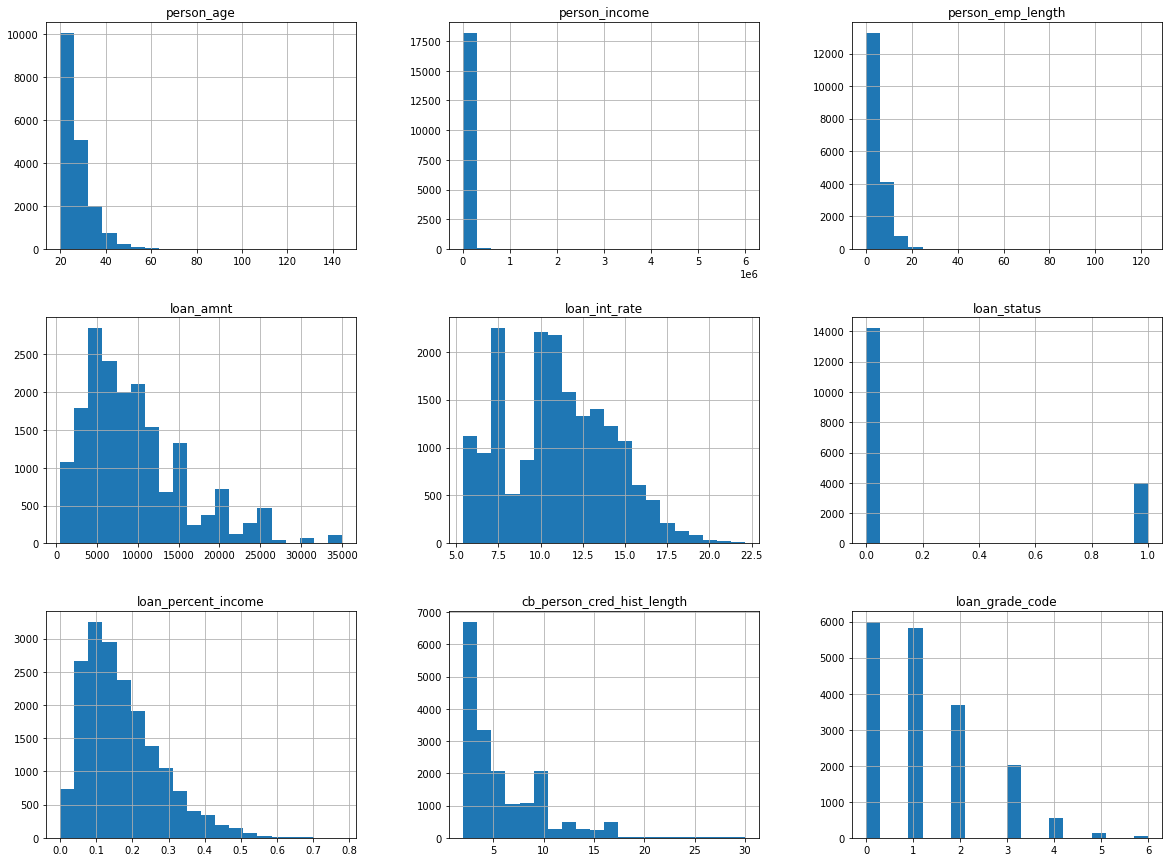

In [49]:
train.hist(bins = 20,figsize =  (20,15));


### Univariate analysis


<AxesSubplot:>

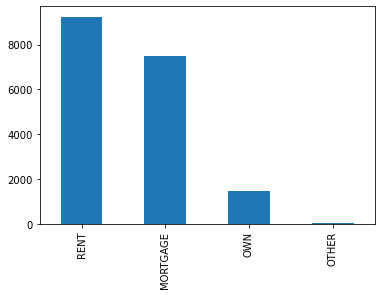

In [43]:
# plotting personal home ownership numbers
train["person_home_ownership"].value_counts().plot.bar()

#### What does the plot tell us? It tells us that there are more people who are taking loans that are renters than those who have mortgages or own homes 

<AxesSubplot:>

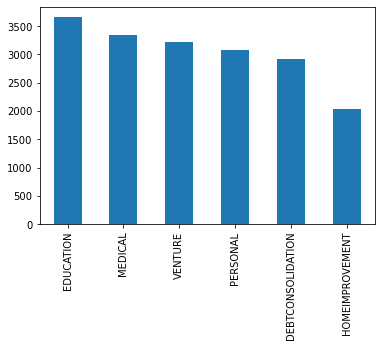

In [44]:
# plotting loan intentions
train["loan_intent"].value_counts().plot.bar()

<AxesSubplot:>

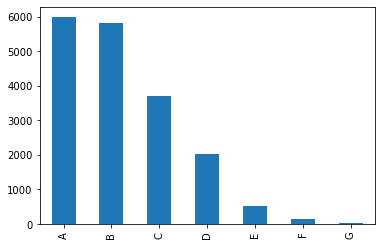

In [45]:
train["loan_grade"].value_counts().plot.bar()

#### The plot tells us that there are more people seeking loans for education. However, the difference among the reasons is not so significant

<AxesSubplot:>

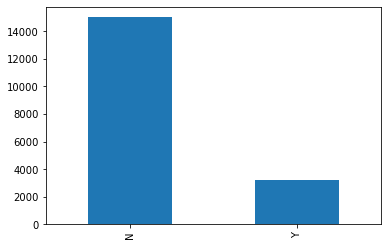

In [46]:
# visualizing the distribution of people who have defaulted
train["cb_person_default_on_file"].value_counts().plot.bar()

#### it appears that that a majority of people do not defult on their loans

In [47]:
# for i, predictor in enumerate(telco_df.drop(columns=['partner','dependents','online_backup','senior_citizen','paperless_billing','churn','tenure', 'gender','total_charges', 'monthly_charges','contract_type_id','payment_type_id', 'internet_service_type_id','contract_type_id','phone_service','streaming_movies','streaming_tv','multiple_lines'])):
#     plt.figure(i)
#     plot= sns.countplot(data=telco_df, x=predictor, hue='churn')
#     plt.setp(plot.get_xticklabels(), rotation=45)    

In [48]:
# import sys
# !{sys.executable} -m pip install pandas-profiling

